# Assignment 10.1 - Convolutional Neural Networks

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf.

#### Please state both names of your group members here:
Jane and John Doe

In [1]:
# Daniel Thompson, Paola Gega

## Task 10.1.1: Training a CNN

First, we recommend using PyTorch for this assignment, a popular machine learning framework. Should be able to install it according to the official instructions on [pytorch.org](https://pytorch.org/).

It might be useful to use [Google Colab](https://colab.research.google.com), too. Google offers some compute, so you are not stuck running your programs locally. You can even use GPUs and TPUs! For this assignment, your local machine should be enough, though. In Google Colab variables might get lost when your computer disconnects from the internet or the notebook runs idle for a while. 

Browse through the [pytorch tutorials ](https://pytorch.org/tutorials/), they often come as colab notebooks - go and execute some!

* Set up your own convolutionnal network of the following structure **(RESULT)**: 
    * 3 convolution layers 
    * 2 fully connected layers 
* Use some padding, stride, pooling, drop out and batch normalization. You should use the ReLU activation function.  **(RESULT)**
* Initialize your model, build a train and test function and display the model's performance on the MNIST classification task. **(RESULT)**

In [2]:
# imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import sys
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Helper functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Some hyperparameters that might be useful for the neural network 
# (adapt them to your needs)

n_epochs = 5    # Total number of training iterations
batch_size_train = 128   # Number of training samples utilized per iteration
batch_size_test = 1000  # Number of test samples utilized per iteration
learning_rate = 0.01
momentum = 0.9  # Momentum for the optimizer (if applicable)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Prepare MNIST data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)
testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                         shuffle=False, num_workers=2)


In [4]:
class CNN(nn.Module):
  def __init__(self, D_out):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128*3*3, 256)
    self.fc2 = nn.Linear(256, D_out)
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [5]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}')
    print(f'Training accuracy: {100 * correct / total:.4f} %')
    return running_loss / len(trainloader), correct / total
    

def test(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test accuracy: {100 * correct / total:.4f} %')
    return correct / total

The model has 390858 trainable parameters

Epoch 1, Loss: 0.3612
Training accuracy: 90.7650 %
Test accuracy: 98.4700 %
Epoch 2, Loss: 0.0799
Training accuracy: 98.0567 %
Test accuracy: 98.6000 %
Epoch 3, Loss: 0.0602
Training accuracy: 98.5900 %
Test accuracy: 98.8800 %
Epoch 4, Loss: 0.0492
Training accuracy: 98.9283 %
Test accuracy: 99.1100 %
Epoch 5, Loss: 0.0418
Training accuracy: 99.0550 %
Test accuracy: 99.1600 %


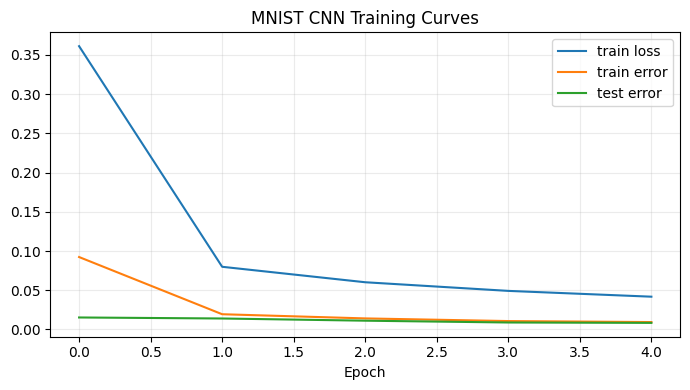

In [6]:
model = CNN(D_out=10).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'The model has {count_parameters(model)} trainable parameters')
print()

train_losses = []
train_accs = []
test_accs = []

# Training loop
for epoch in range(n_epochs):
    train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_acc = test(model, device, testloader, criterion)
    test_accs.append(test_acc)

# Plot training history
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="train loss")
plt.plot([1-a for a in train_accs], label="train error")
plt.plot([1-a for a in test_accs], label="test error")
plt.title("MNIST CNN Training Curves")
plt.xlabel("Epoch")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

## Task 10.1.2: Compare vs fully connected network

* Compare the performance of your CNN to a fully connected network of similar size (number of parameters). **(RESULT)**
* Plot training and test accuracy/loss curves for both models. Train each for 2 epochs. **(RESULT)**

In [7]:
class SimpleFC(nn.Module):
    def __init__(self):
        super(SimpleFC, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The model has 535818 trainable parameters

Epoch 1, Loss: 0.2807
Training accuracy: 94.1283 %
Test accuracy: 94.4100 %
Epoch 2, Loss: 0.1667
Training accuracy: 96.9750 %
Test accuracy: 95.6000 %
Epoch 3, Loss: 0.1458
Training accuracy: 97.3067 %
Test accuracy: 96.0400 %
Epoch 4, Loss: 0.1321
Training accuracy: 97.6350 %
Test accuracy: 96.1900 %
Epoch 5, Loss: 0.1332
Training accuracy: 97.6050 %
Test accuracy: 96.1400 %


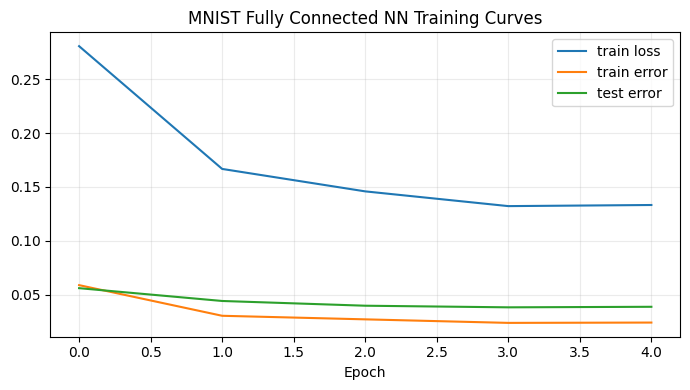

In [8]:
model = SimpleFC().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'The model has {count_parameters(model)} trainable parameters')
print()

train_losses = []
train_accs = []
test_accs = []

# Training loop
for epoch in range(n_epochs):
    train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_acc = test(model, device, testloader, criterion)
    test_accs.append(test_acc)

# Plot training history
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="train loss")
plt.plot([1-a for a in train_accs], label="train error")
plt.plot([1-a for a in test_accs], label="test error")
plt.title("MNIST Fully Connected NN Training Curves")
plt.xlabel("Epoch")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

**Report:** As we can see from the plots, the convolutional network outperforms the fully-connected one despite having a slightly smaller number of parameters.

## Congratz, you made it! :)